In [1]:
import fastf1.plotting
import f1analytics as f1

In [2]:
# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl(color_scheme='fastf1' )

session_year = 2024
session_name = "Singapore Grand Prix"
session_type = 'Q'


# load a session and its telemetry data
session = fastf1.get_session(session_year, session_name, session_type)
session.load()
laps = session.laps

results = session.results

circuit_info = session.get_circuit_info()

weather = session.weather_data



req         WARNING 	DEFAULT CACHE ENABLED! (3.43 GB) /Users/PietroPaolo/Library/Caches/fastf1


core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '44', '63', '81', '27', '14', '22', '16', '55', '23', '43', '11', '20', '31', '3', '18', '10', '77', '24']


In [3]:
t = f1.telemetry.Telemetry(
    session=session,
    session_name=session_name,
    year=session_year,
    session_type=session_type
)

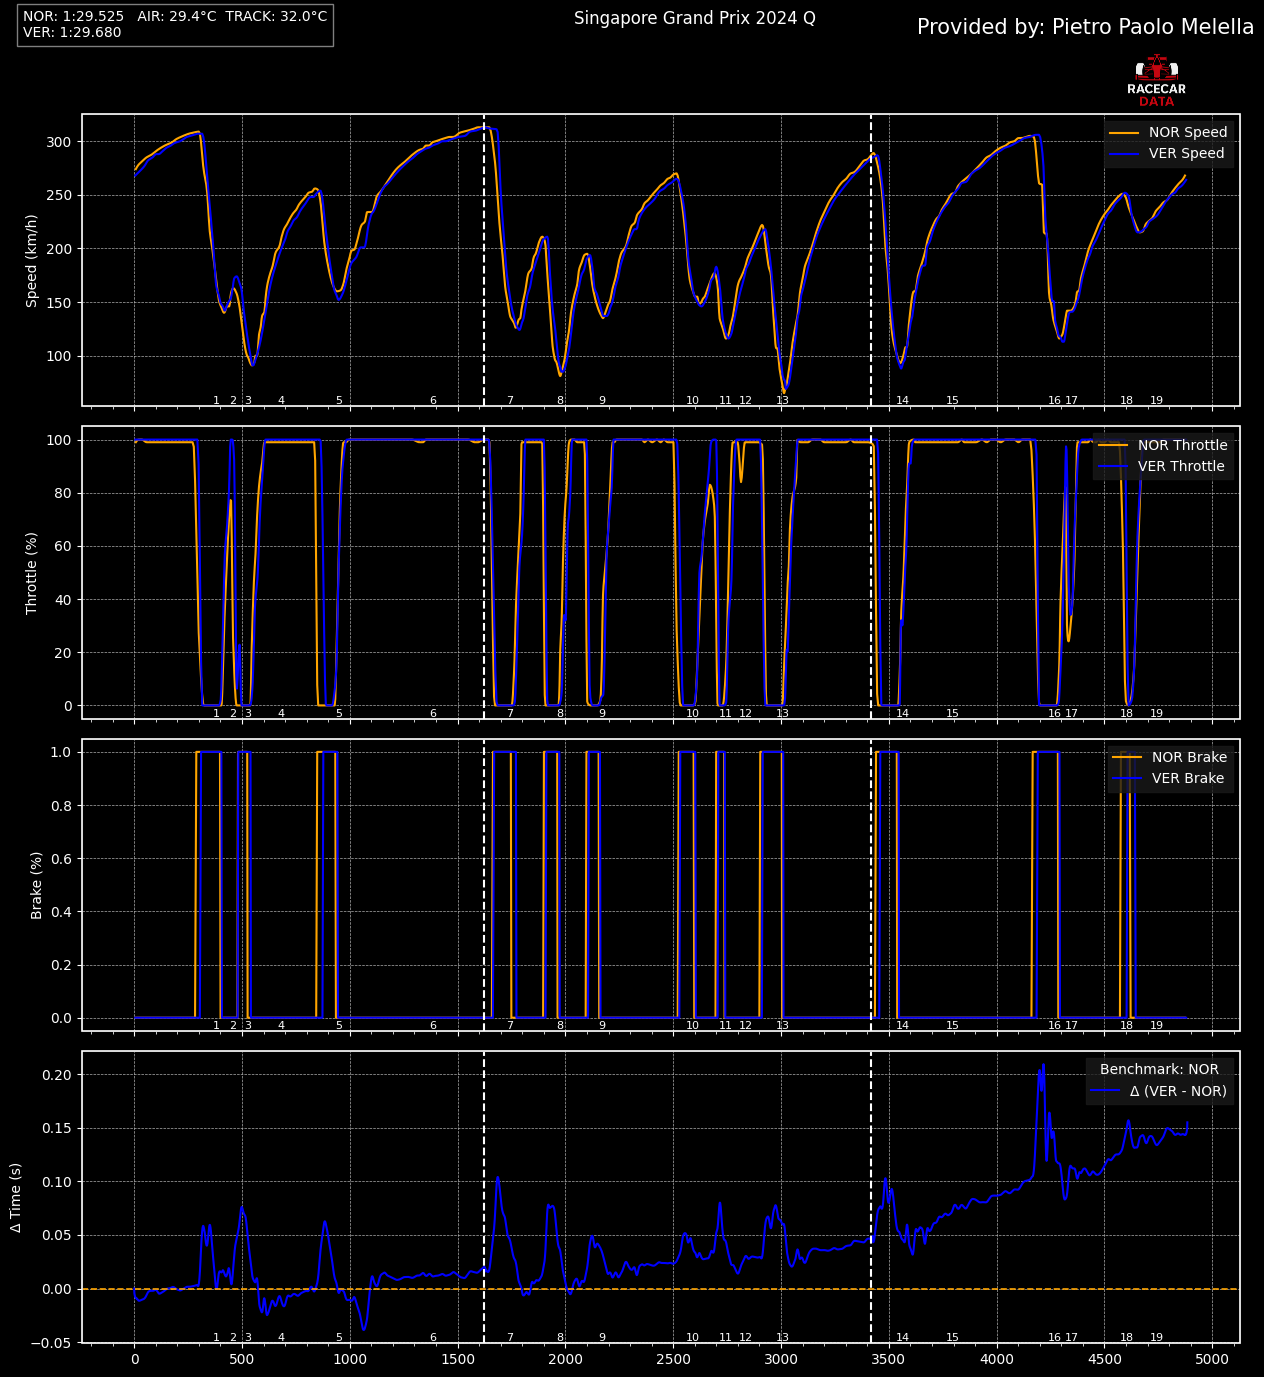

In [4]:
t.compare_laps(
    drivers={'NOR': 'fastest', 'VER': 'fastest'},
    channels=['Speed', 'Throttle', 'Brake','Delta'],
    session_label=session_type
)

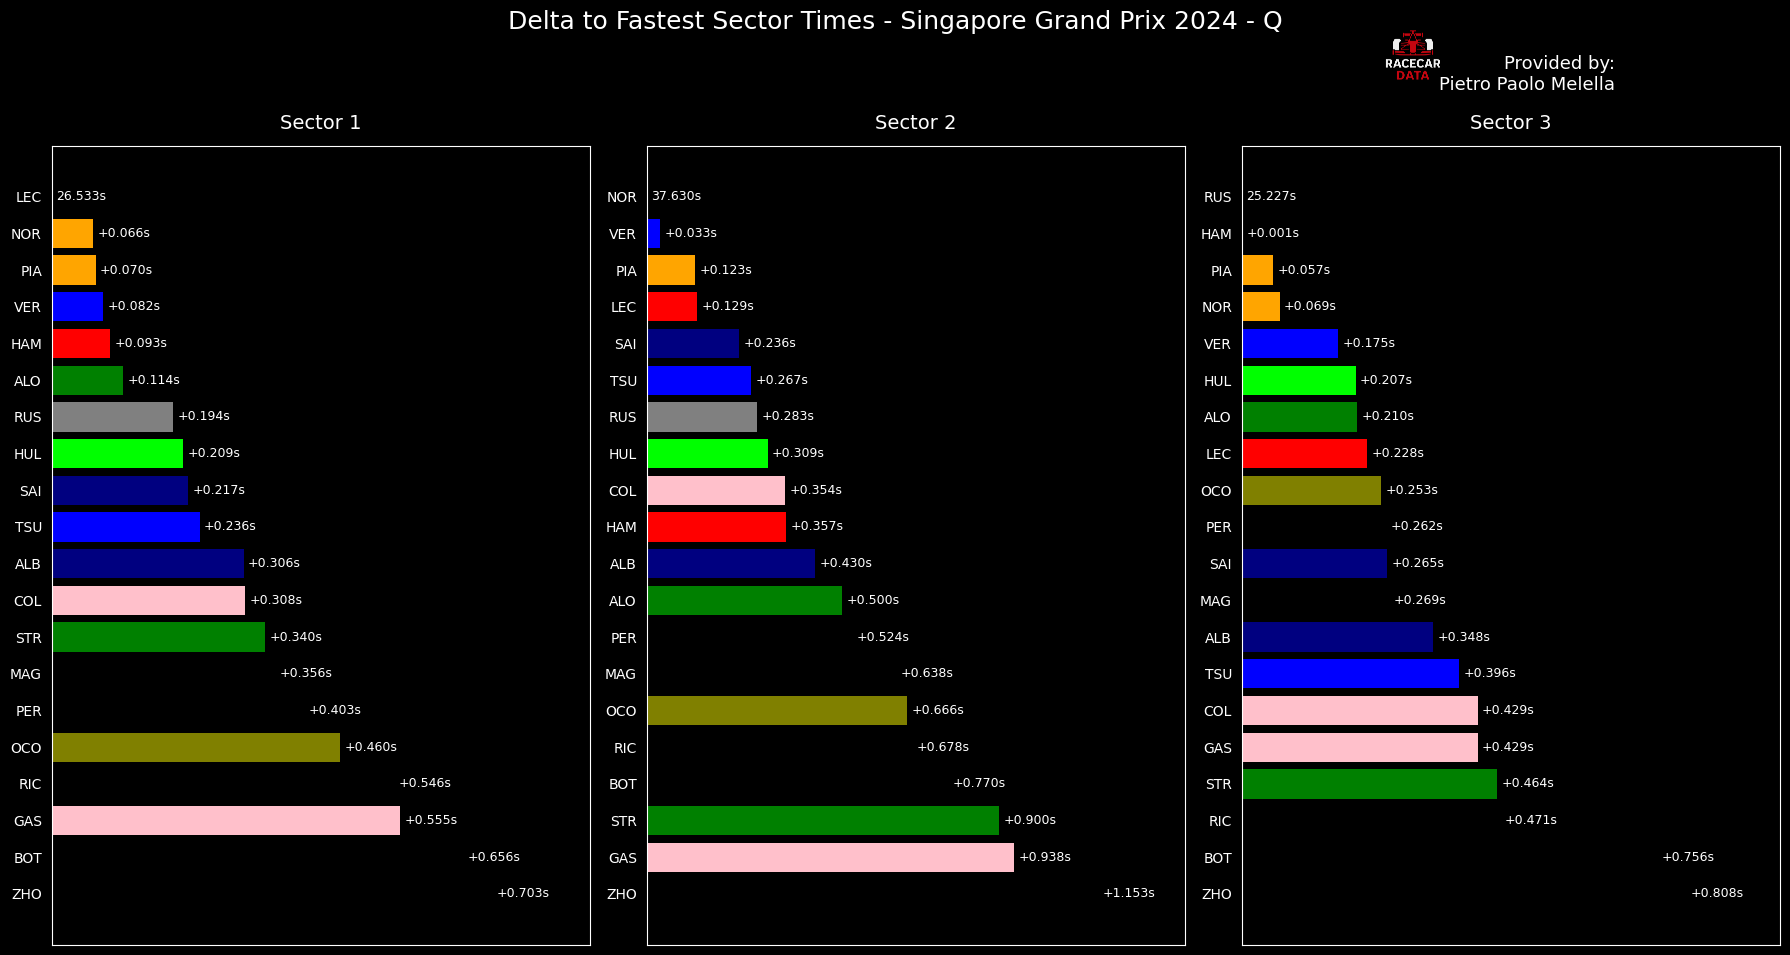

In [5]:
sd = f1.fastest_sectors_deltas.SectorDeltaPlotter(
    session, session_name, session_year, session_type
)
sd.plot()

In [9]:
from typing import Optional, List
from dataclasses import dataclass, field
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import mplcursors
import os
import sys  # for logo path manipulation    

@dataclass
class TrackTelemetryVisualizer:
    """
    Enhanced interactive plot of a driver's fastest lap telemetry.

    Features:
      - Color by one channel (B→G→R or plasma)
      - Variable linewidth by a second channel (e.g. speed)
      - Corner annotations
      - Sector boundary markers
      - Brake/low-throttle highlights
      - Interactive tooltips via mplcursors
      - Auto-title and save() method
    """
    laps: any                                  # pre-filtered laps DataFrame
    circuit_info: any                          # session.get_circuit_info()
    driver: str                               # driver code
    color_channel: str = 'Throttle'           # channel for color
    width_channel: Optional[str] = 'Speed'    # channel for width, None to disable
    annotate_corners: bool = False            # show corner labels
    highlight_brake: bool = False             # mark throttle < threshold
    brake_threshold: float = 10.0             # throttle % threshold
    annotate_sectors: bool = False            # mark sector boundaries
    event_name: Optional[str] = None          # for title
    year: Optional[int] = None
    session_name: Optional[str] = None
    use_bgr_scale: bool = False

    # internal fields populated in __post_init__
    x: np.ndarray = field(init=False)
    y: np.ndarray = field(init=False)
    data_color: np.ndarray = field(init=False)
    data_width: np.ndarray = field(init=False)
    segments: np.ndarray = field(init=False)

    def __post_init__(self):
        # extract telemetry
        lap = self.laps.pick_drivers([self.driver]).pick_fastest()
        tel = lap.telemetry
        self.x = tel['X'].values
        self.y = tel['Y'].values
        self.data_color = tel[self.color_channel].values
        if self.width_channel:
            self.data_width = tel[self.width_channel].values
        else:
            self.data_width = np.full_like(self.data_color, fill_value=1.0)
        # build segments
        pts = np.vstack([self.x, self.y]).T.reshape(-1,1,2)
        self.segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
        # store rotation angle
        self._angle = self.circuit_info.rotation / 180 * np.pi
        # store lap for sector annotations
        self._lap = lap

    @staticmethod
    def _rotate(xy: np.ndarray, *, angle: float) -> np.ndarray:
        mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
        return xy.dot(mat)

    def plot(self,
             track_color: str = '#888888',
             bg_linewidth: float = 14.0,
             data_linewidth: float = 4.0,
             figsize=(12,7),
             colorbar_orientation: str = 'vertical'):
        """
        Render the lap with:
          - grey outline (bg_linewidth)
          - B→G→R or plasma telemetry coloring
          - variable linewidth by width_channel
          - optional corner annotations
          - sector boundary markers
          - brake/low-throttle highlights
          - interactive tooltips
          - vertical colorbar with ticks at min/mid/max
          - automatic title if event_name/year/session_name provided
        """
        # Prepare figure and axes
        fig, ax = plt.subplots(figsize=figsize, facecolor='#222222')
        ax.set_facecolor('#222222')
        ax.axis('off')

        # Rotate coordinates to circuit orientation
        coords = np.vstack([self.x, self.y]).T
        rot = self._rotate(coords, angle=self._angle)
        X, Y = rot[:,0], rot[:,1]
        pts = rot.reshape(-1,1,2)
        segs = np.concatenate([pts[:-1], pts[1:]], axis=1)

        # Draw track outline
        ax.plot(X, Y,
                color=track_color,
                linewidth=bg_linewidth,
                solid_capstyle='round',
                zorder=0)

        # Choose colormap
        cmap = (LinearSegmentedColormap.from_list('bgr',['blue','green','red'])
                if self.use_bgr_scale else mpl.cm.plasma)
        vmin, vmax = self.data_color.min(), self.data_color.max()
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        # Compute variable linewidths safely
        if self.data_width.max() != self.data_width.min():
            widths = (
                0.5
                + 4 * (self.data_width - self.data_width.min())
                / (self.data_width.max() - self.data_width.min())
            )
        else:
            widths = np.full_like(self.data_color, 2.0)

        # Plot telemetry LineCollection
        lc = LineCollection(segs,
                            cmap=cmap,
                            norm=norm,
                            linewidth=widths,
                            capstyle='butt',
                            zorder=1)
        lc.set_array(self.data_color)
        ax.add_collection(lc)

        # Interactive tooltips
        cursor = mplcursors.cursor(lc, hover=True)
        @cursor.connect("add")
        def on_add(sel):
            idx = sel.target.index
            txt = f"{self.color_channel}: {self.data_color[idx]:.1f}"
            if self.width_channel:
                txt += f"\n{self.width_channel}: {self.data_width[idx]:.1f}"
            sel.annotation.set_text(txt)
            sel.annotation.get_bbox_patch().set(fc='white', alpha=0.8)

        # Highlight brake/low-throttle zones
        if self.highlight_brake:
            idxs = np.where(self.data_color < self.brake_threshold)[0]
            ax.scatter(rot[idxs,0], rot[idxs,1],
                       color='white', edgecolor='black',
                       s=30, zorder=2, label='Brake')

                        # Sector boundary markers (approximate by geometry)
        if self.annotate_sectors:
            # compute cumulative distance along the raw track
            coords_raw = np.vstack([self.x, self.y]).T
            deltas = np.linalg.norm(np.diff(coords_raw, axis=0), axis=1)
            cumdist = np.insert(np.cumsum(deltas), 0, 0)
            total = cumdist[-1]
            # place markers at 1/3 and 2/3 of lap distance
            for frac in (1/3, 2/3):
                target = total * frac
                i = np.argmin(np.abs(cumdist - target))
                # rotate and plot
                pt = coords_raw[i]
                rpt = self._rotate(pt.reshape(1,2), angle=self._angle)[0]
                ax.scatter(rpt[0], rpt[1], color='yellow', s=70, edgecolor='black', zorder=2)

        # Corner annotations
        if self.annotate_corners:
            offset = np.array([500, 0])
            for _, c in self.circuit_info.corners.iterrows():
                base = np.array([c['X'], c['Y']])
                offp = self._rotate(offset, angle=c['Angle']/180*np.pi)
                txtp = self._rotate(base+offp, angle=self._angle)
                bp   = self._rotate(base, angle=self._angle)
                ax.scatter(txtp[0], txtp[1],
                           color='white', s=150,
                           edgecolor='grey', linewidth=1.5, zorder=2)
                ax.plot([bp[0],txtp[0]], [bp[1],txtp[1]],
                        color='grey', linewidth=1.0, zorder=1)
                ax.text(txtp[0], txtp[1], f"{c['Number']}{c['Letter']}",
                        ha='center', va='center', color='black', fontsize=9, zorder=3)

        # Colorbar with ticks at min/mid/max
        cbar = fig.colorbar(lc, ax=ax,
                            orientation=colorbar_orientation,
                            pad=0.02, shrink=0.6)
        mid = 0.5*(vmin+vmax)
        cbar.set_ticks([vmin, mid, vmax])
        cbar.set_ticklabels([f"{vmin:.0f}", f"{mid:.0f}", f"{vmax:.0f}"])
        cbar.ax.yaxis.set_tick_params(labelsize=10, color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
        cbar.set_label(self.color_channel,
                       labelpad=10, fontsize=12, color='white')

        # Automatic title
        if self.event_name and self.year and self.session_name:
            full = f"{self.event_name} {self.year} {self.session_name}, {self.driver} — {self.color_channel}"
            ax.set_title(full, fontsize=16, color='white', pad=20)
            
        # Annotate signature
        fig.text(
            0.92, 0.87,
            "Provided by: Pietro Paolo Melella",
            ha='right', va='bottom',
            color='white', fontsize=15
        )
        # Add logo below the "Provided by" text
        sys.path.append('/Users/PietroPaolo/Desktop/GitHub/F1/')
        logo_path = os.path.join('/Users/PietroPaolo/Desktop/GitHub/F1/', 'logo-square.png')  # or .jpg etc.

        if os.path.exists(logo_path):
            logo_img = mpimg.imread(logo_path)
            # [left, bottom, width, height] — values are in 0–1 relative figure coords
            logo_ax = fig.add_axes([0.80, 0.89, 0.12, 0.12], anchor='NE', zorder=10)
            logo_ax.imshow(logo_img)
            logo_ax.axis('off')
        else:
            print(f"[WARN] Logo file not found at: {logo_path}")

        plt.show()


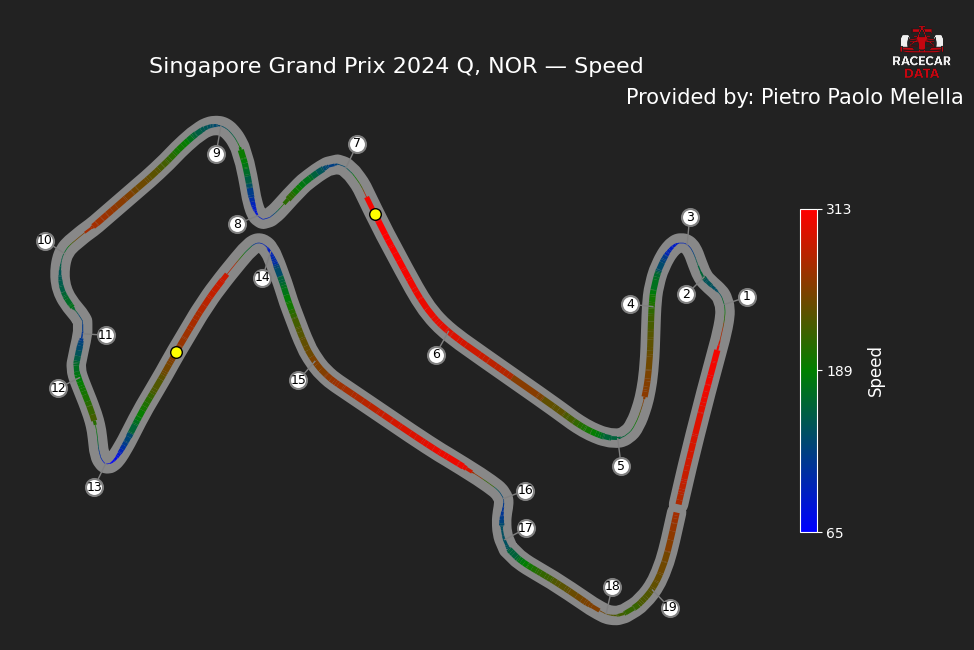

In [13]:
vis1 = TrackTelemetryVisualizer(
    laps=laps,
    circuit_info=circuit_info,
    driver='NOR',
    color_channel='Speed',
    width_channel='Throttle',
    annotate_corners=True,
    highlight_brake=False,      # ← disable the white‐dot brake markers
    annotate_sectors=True,     # leave sector markers off
    event_name='Singapore Grand Prix',
    year=2024,
    session_name='Q',
    use_bgr_scale=True
)
vis1.plot()